In [3]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats
import scipy.optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
# load data from yfinance, format in CSV-File and prepare for usage


#yfinance.download(['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', 'ASML', 'TMO', 'NVDA', 'AMZN', 'SU.PA', '^GSPC'], interval='1mo').to_csv('combined.csv')
#pd.read_csv('combined.csv')[['Price', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4', 'Close.5', 'Close.6', 'Close.7', 'Close.8', 'Close.9', 'Close.10']].dropna().to_csv('data.csv', index=False)


data = pd.read_csv('data.csv',index_col=['Date'],date_format=['Date'])

ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', 'ASML', 'TMO', 'NVDA', 'AMZN', 'SU.PA']


for i in range(len(ticker)):
    data.loc[:, "logreturn_" + ticker[i]] = np.log(data[ticker[i]]) - np.log(data[ticker[i]].shift())

data = data.dropna()

data.head()


KeyError: 'ASML'

# Checking for normal distribution

With an alpha of 0.05

In [ ]:
JB = np.zeros((len(ticker)))



for i in range(len(ticker)):
    S = scipy.stats.skew(data["logreturn_" + ticker[i]])
    K = scipy.stats.kurtosis(data["logreturn_" + ticker[i]], fisher=False)
    N = data.shape[0]
    JB[i] = (N / 6) * (S**2 + 0.25 * (K - 3)**2)


JB
    

array([1.59329498, 0.28119686, 1.59635315, 4.86882638, 1.41896856,
       0.95634183, 0.55711059, 5.32523237, 4.72522601, 0.59944983])

In [ ]:
cdf = np.zeros((len(ticker)))

for i in range(len(ticker)):
    cdf[i] = scipy.stats.chi2.cdf(JB[i], 2)

cdf


array([0.54916213, 0.13116186, 0.54985097, 0.91235083, 0.50810219,
       0.38008377, 0.24312358, 0.93023454, 0.90582618, 0.25897796])

In [ ]:
a = 0.05

p = np.zeros((len(ticker)))

for i in range(len(ticker)):
    p[i] = 1 - cdf[i]
    if p[i] > a:
        print(ticker[i] + ": probably normal distributed")
    else: 
        print(ticker[i] + ": not normal distributen")

p

AAPL: probably normal distributed
MSFT: probably normal distributed
TSLA: probably normal distributed
ORSTED.CO: probably normal distributed
V: probably normal distributed
ASML: probably normal distributed
TMO: probably normal distributed
NVDA: probably normal distributed
AMZN: probably normal distributed
SU.PA: probably normal distributed


array([0.45083787, 0.86883814, 0.45014903, 0.08764917, 0.49189781,
       0.61991623, 0.75687642, 0.06976546, 0.09417382, 0.74102204])

## Interpretation

The analysis using the Jarque-Bera test indicates, that IBE.MC and INRG.L are not normal distributed. This deviation implies a higher likelihood of extreme return outcomes than predicted by the normal distribution assumption. As a result, mean-variance optimization — which relies on variance as a complete risk measure — may underestimate the true risk of these assets.

# Build the IOS

In [ ]:

mu = np.zeros((len(ticker)))

for i in range(len(ticker)):
    mu[i] = np.mean(data["logreturn_" + ticker[i]])*12

#Sigma = np.cov(data[['logreturn_ENEL.MI', 'logreturn_IBE.MC', 'logreturn_INRG.L', 'logreturn_ORSTED.CO', 'logreturn_RWE.DE']].T)*12


Sigma = np.cov(data[['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V', 'logreturn_ASML', 'logreturn_TMO', 'logreturn_NVDA', 'logreturn_AMZN', 'logreturn_SU.PA']].T)*12

print(mu)
print(Sigma)


[0.25445661 0.25780211 0.35977795 0.01542285 0.18577064 0.2360084
 0.11780901 0.53438553 0.19608975 0.18213605]
[[0.07358141 0.03236707 0.08864285 0.02272463 0.02718902 0.0405197
  0.02434536 0.07297983 0.04711493 0.02885734]
 [0.03236707 0.03846375 0.05142549 0.01293582 0.01854998 0.04347657
  0.02052974 0.05929644 0.04050126 0.02481424]
 [0.08864285 0.05142549 0.36725035 0.02183648 0.02858627 0.05801398
  0.04460131 0.09828906 0.09136547 0.05845132]
 [0.02272463 0.01293582 0.02183648 0.09306158 0.00942402 0.03027561
  0.02413549 0.0287825  0.01684924 0.01867476]
 [0.02718902 0.01854998 0.02858627 0.00942402 0.0394781  0.02830395
  0.0142007  0.03079441 0.02673819 0.02052555]
 [0.0405197  0.04347657 0.05801398 0.03027561 0.02830395 0.09699875
  0.03555406 0.09167213 0.04995898 0.0446385 ]
 [0.02434536 0.02052974 0.04460131 0.02413549 0.0142007  0.03555406
  0.05292435 0.03541685 0.03440373 0.02472668]
 [0.07297983 0.05929644 0.09828906 0.0287825  0.03079441 0.09167213
  0.03541685 0.2

# Building a Efficient Frontier

## 1. unconstrained

In [ ]:
def portfolio_variance(w):
    #input: w as  numpy column vector
    #output: scalar
    return (w.T@Sigma@w).item()

def eq_portfolio_return(w):
    #input: numpy portfolio column vector
    #note: mu_i is a global variable; needs to be known before calling this function
    #output: difference between w's expected return and the target return; scalar
    
    return (w.T@mu).item() - mu_i #constraint to meet target expected return mu_i


def eq_weight_sum(w): 
    #content: full investment constraint: 100% is invested in risky assets
    #input: numpy portfolio column vector
    #output: difference between sum of portfolio holdings and 100%=1. 
    
    return np.sum(w) - 1

#starting values
w0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] #equal weight for each asset

#bounds 
bounds = [(0, 1),(0, 1),(0, 1),(0, 1),(0, 1),(0, 1),(0, 1),(0, 1),(0, 1),(0, 1)]

#constrains
constraints = [{'type': 'eq', 'fun': eq_portfolio_return},
               {'type': 'eq', 'fun': eq_weight_sum}
               ] #target return and full investment constraint

In [ ]:
#loop through y-axis

mu_min = 0.01
mu_max = 1
incr = 0.001

In [ ]:
#number of evaluations (i.e. number of optimizations)
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [ ]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 10))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_86982/852197012.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


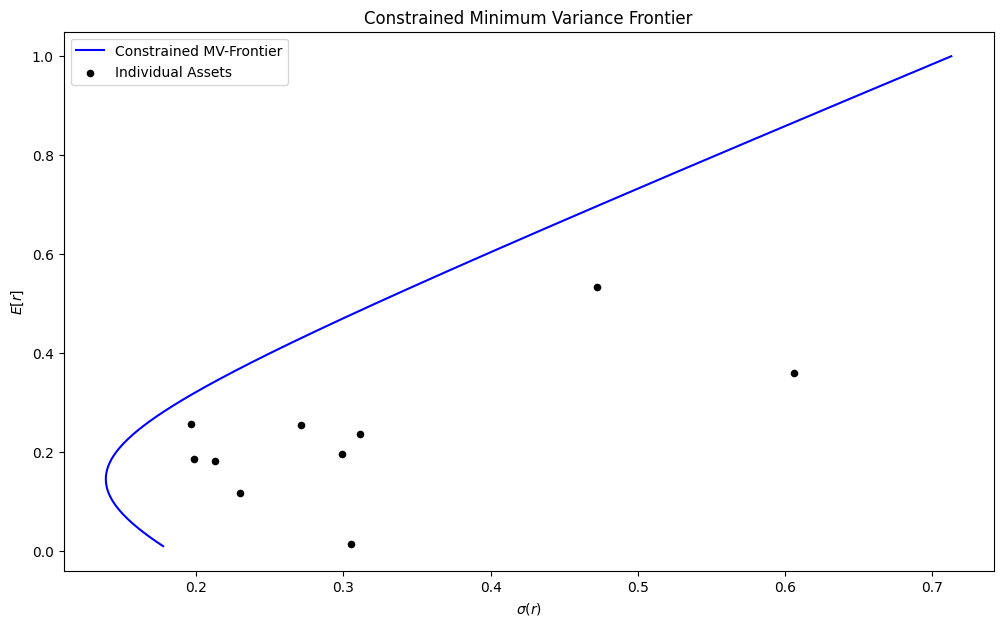

In [ ]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

In [ ]:
p = 990

print(mu_MV[p])
print(w_MV[p])
print(np.sum(w_MV[p]))

print(np.argmin(sigma_MV))

0.9999999999852317
[-0.06994411  2.52327559  0.30336277 -0.83643947  0.81914171 -0.58482514
 -0.05901621  1.37886938 -1.59908324 -0.87534127]
1.0
136


## 2. Constrained
To ensure realistic implementable portfolio weight, we allow no short-positions and no leverage.

In [ ]:
#loop through y-axis

mu_min = 0.01
mu_max = 0.2
incr = 0.001

In [ ]:
#number of evaluations (i.e. number of optimizations)
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

191

In [ ]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 10))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

# Tangency Portfolio
 As the risk-free rate, we choose Germany's 10-Year Bond with a 2.7% return.

In [ ]:
rf = 0.027

SR_MV = (mu_MV - rf) / sigma_MV

TP_index = np.argmax(SR_MV)

TP_index

190

In [ ]:
w_TP = w_MV[TP_index]
w_TP

array([0.00000000e+00, 4.34130874e-01, 1.49305393e-17, 6.01944146e-02,
       3.32024355e-01, 0.00000000e+00, 9.57076764e-02, 0.00000000e+00,
       0.00000000e+00, 7.79426809e-02])

In [ ]:
w_TP = w_MV[TP_index]
w_TP

0.19999999999094173

In [ ]:
sigma_TP = sigma_MV[TP_index]
sigma_TP

0.15897142190975272

In [ ]:
SR_TP = (mu_TP - rf) / sigma_TP
SR_TP

1.0882459118290642

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_86982/907976700.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


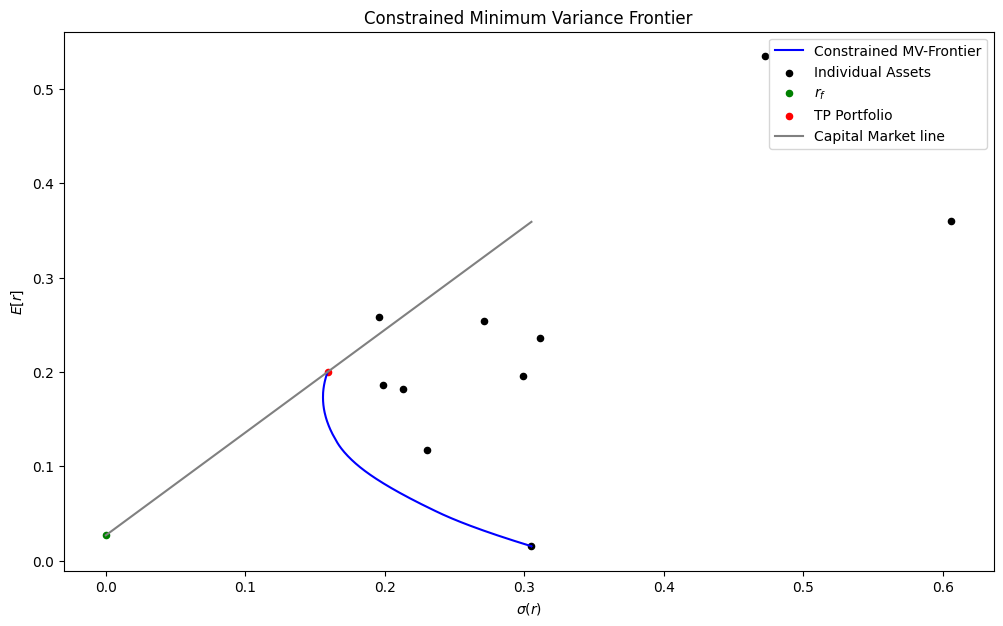

In [ ]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities and risk-free asset
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')
plt.scatter([0], [rf], s = 20, color='green', label='$r_f$')
plt.scatter(sigma_TP, mu_TP, s = 20, color='red', label='TP Portfolio')

# add capital market line
x = np.linspace(0, np.max(sigma_MV))
y = rf + SR_TP * x
plt.plot(x, y, color='grey', label='Capital Market line')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

# Optimal Complete Portfolio

Ris Aversion = 3 (medium)

In [ ]:
A = 5

y = (mu_TP - rf) / (A * (sigma_TP ** 2))

y

1.369108860895584

# Decomposing expected portfolio performance (return and risk) using CAPM Model

In [ ]:
#get sp500 data and log-return

data['logreturn_sp500'] = np.log(data['^GSPC']) - np.log(data['^GSPC'].shift())

data = data.dropna()

data.head()

,AAPL,AMZN,ASML,MSFT,NVDA,ORSTED.CO,SU.PA,TMO,TSLA,V,^GSPC,logreturn_AAPL,logreturn_MSFT,logreturn_TSLA,logreturn_ORSTED.CO,logreturn_V,logreturn_ASML,logreturn_TMO,logreturn_NVDA,logreturn_AMZN,logreturn_SU.PA,logreturn_sp500
Date,,,,,,,,,,,,,,,,,,,,,,
2016-09-01,25.977859,41.865501,100.740158,51.652515,1.685230,241.362564,50.013790,155.304199,13.602000,77.817398,2168.270020,0.068851,0.008647,-0.038366,0.038174,0.023739,0.028041,0.044151,0.112535,0.084895,0.015754,-0.001235
2016-10-01,26.090454,39.491001,97.099625,53.732952,1.750160,235.833206,49.272366,143.705536,13.182000,77.638603,2126.149902,0.004325,0.039488,-0.031365,-0.023175,-0.002300,-0.036807,-0.077619,0.037805,-0.058389,-0.014935,-0.019617
2016-11-01,25.396492,37.528500,94.810478,54.037853,2.267633,210.204880,50.626266,136.942047,12.626667,72.755051,2198.810059,-0.026958,0.005658,-0.043041,-0.115042,-0.064966,-0.023858,-0.048208,0.259029,-0.050972,0.027107,0.033604
2016-12-01,26.751026,37.493500,103.148804,56.100174,2.629170,234.867752,53.277660,137.909668,14.246000,73.568230,2238.830078,0.051962,0.037454,0.120665,0.110940,0.011115,0.084293,0.007041,0.147932,-0.000933,0.051047,0.018037
2017-01-01,28.028290,41.174000,111.606636,58.366207,2.689272,228.811752,53.366302,149.098404,16.795334,77.990601,2278.870117,0.046642,0.039598,0.164625,-0.026123,0.058375,0.078808,0.078008,0.022602,0.093639,0.001662,0.017726
